In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ("bon", 8, 4)

data = load_data(epoch_key)

Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


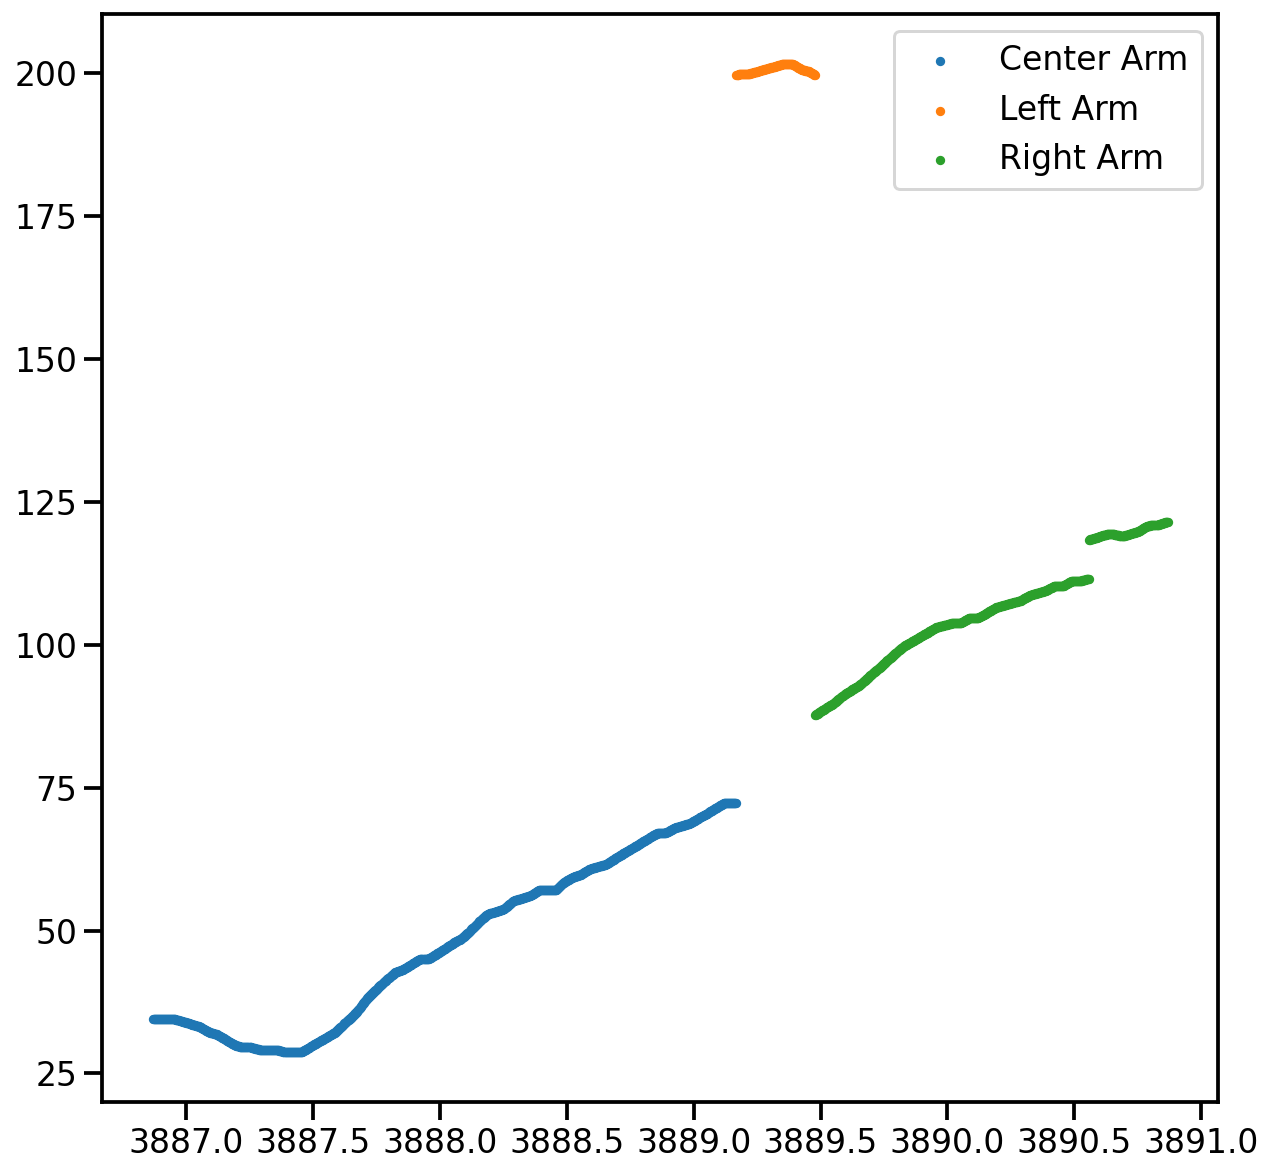

In [4]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in (
    data["position_info"].reset_index().set_index(t).loc[time_slice].groupby("arm_name")
):
    ax.scatter(
        df.index,
        df.linear_position,
        s=10,
        label=task,
    )

plt.legend()

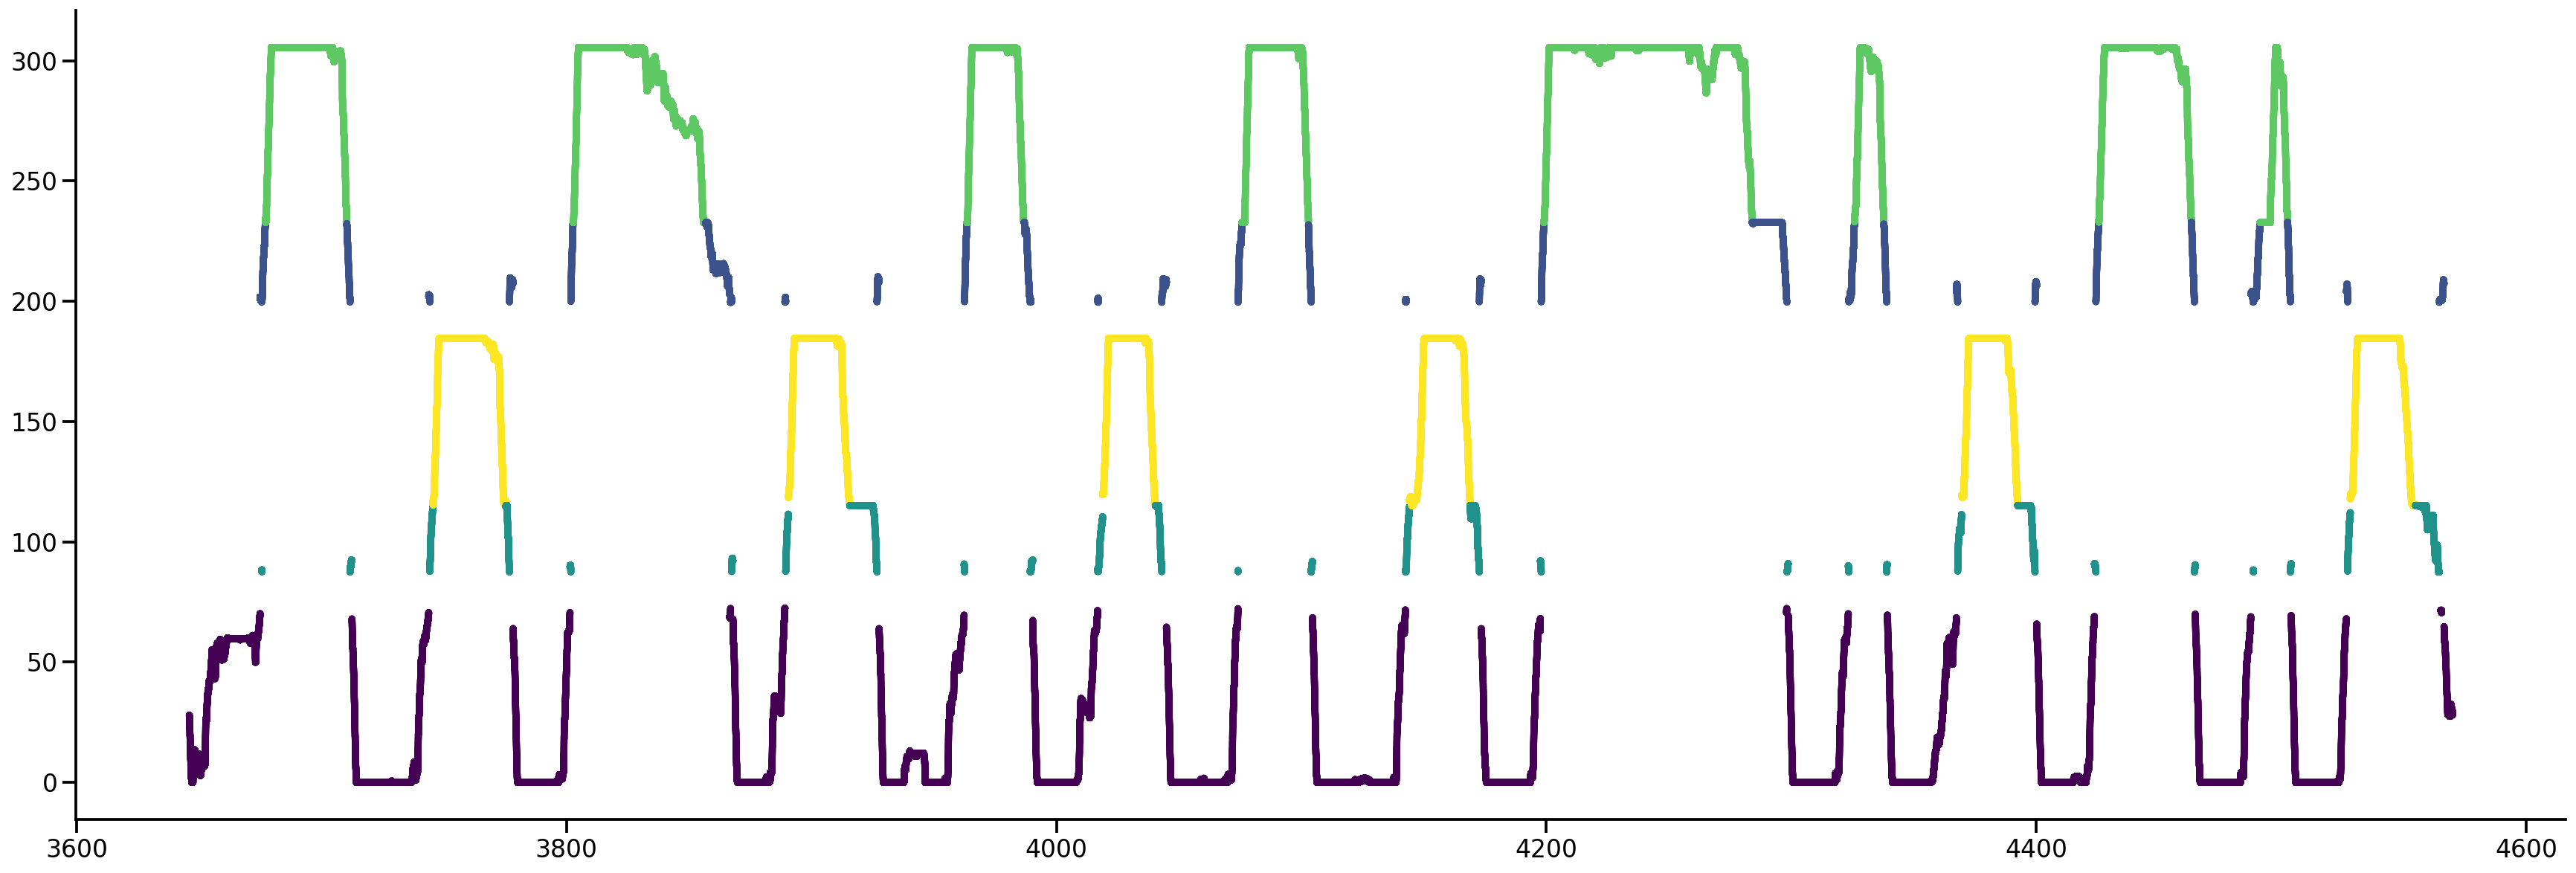

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

ax.scatter(
    data["position_info"].index / np.timedelta64(1, "s"),
    data["position_info"].linear_position,
    c=data["position_info"].track_segment_id,
    s=10,
)
sns.despine()

In [8]:
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.parameters import ANIMALS

is_running = data["position_info"].speed > 4
is_outbound = data["position_info"].task == "Outbound"

track_labels = data["position_info"].arm_name

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

Inbound
Outbound


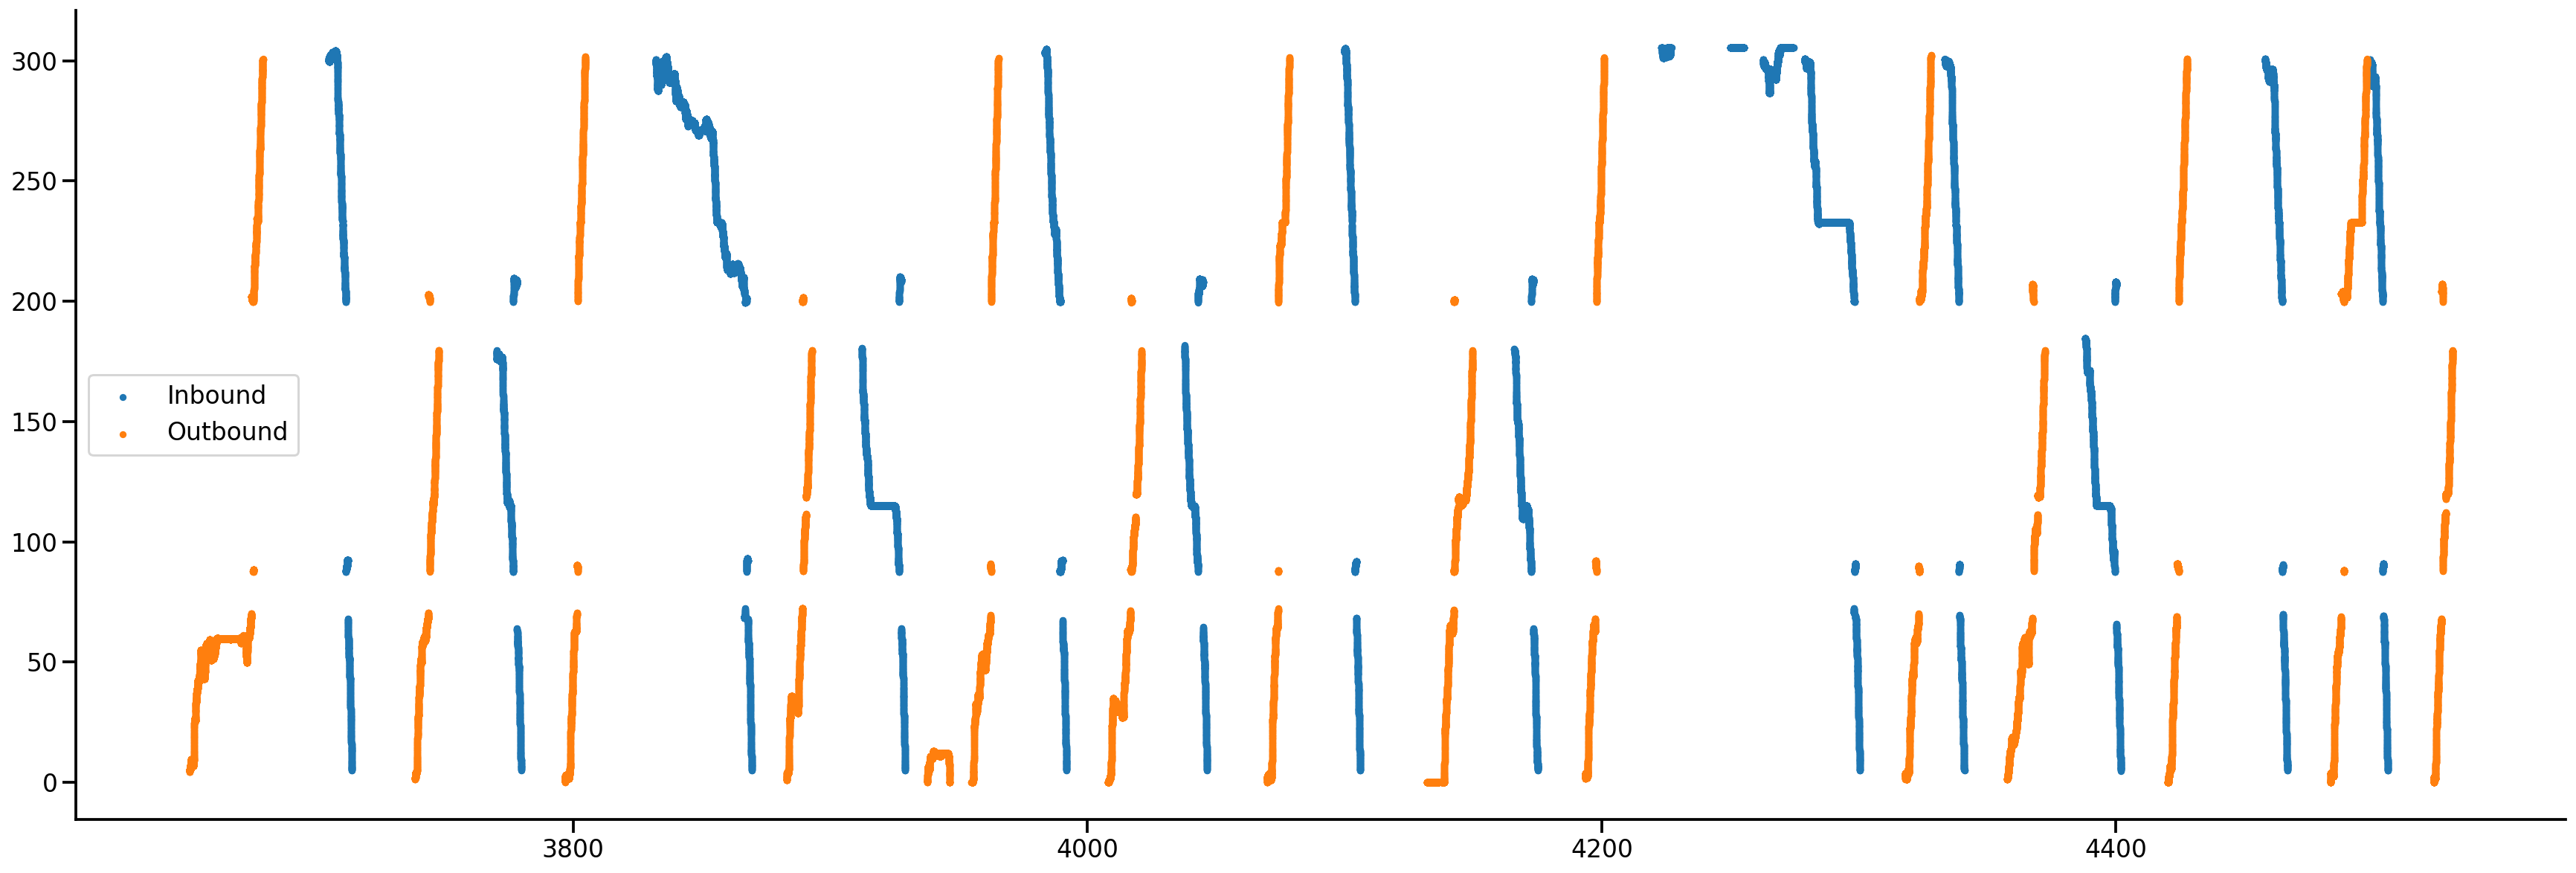

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for task, df in data["position_info"].groupby("task"):
    print(task)
    ax.scatter(
        df.index / np.timedelta64(1, "s"),
        df.linear_position,
        s=10,
        label=task,
    )

plt.legend()
sns.despine()

Center Arm
Left Arm
Right Arm


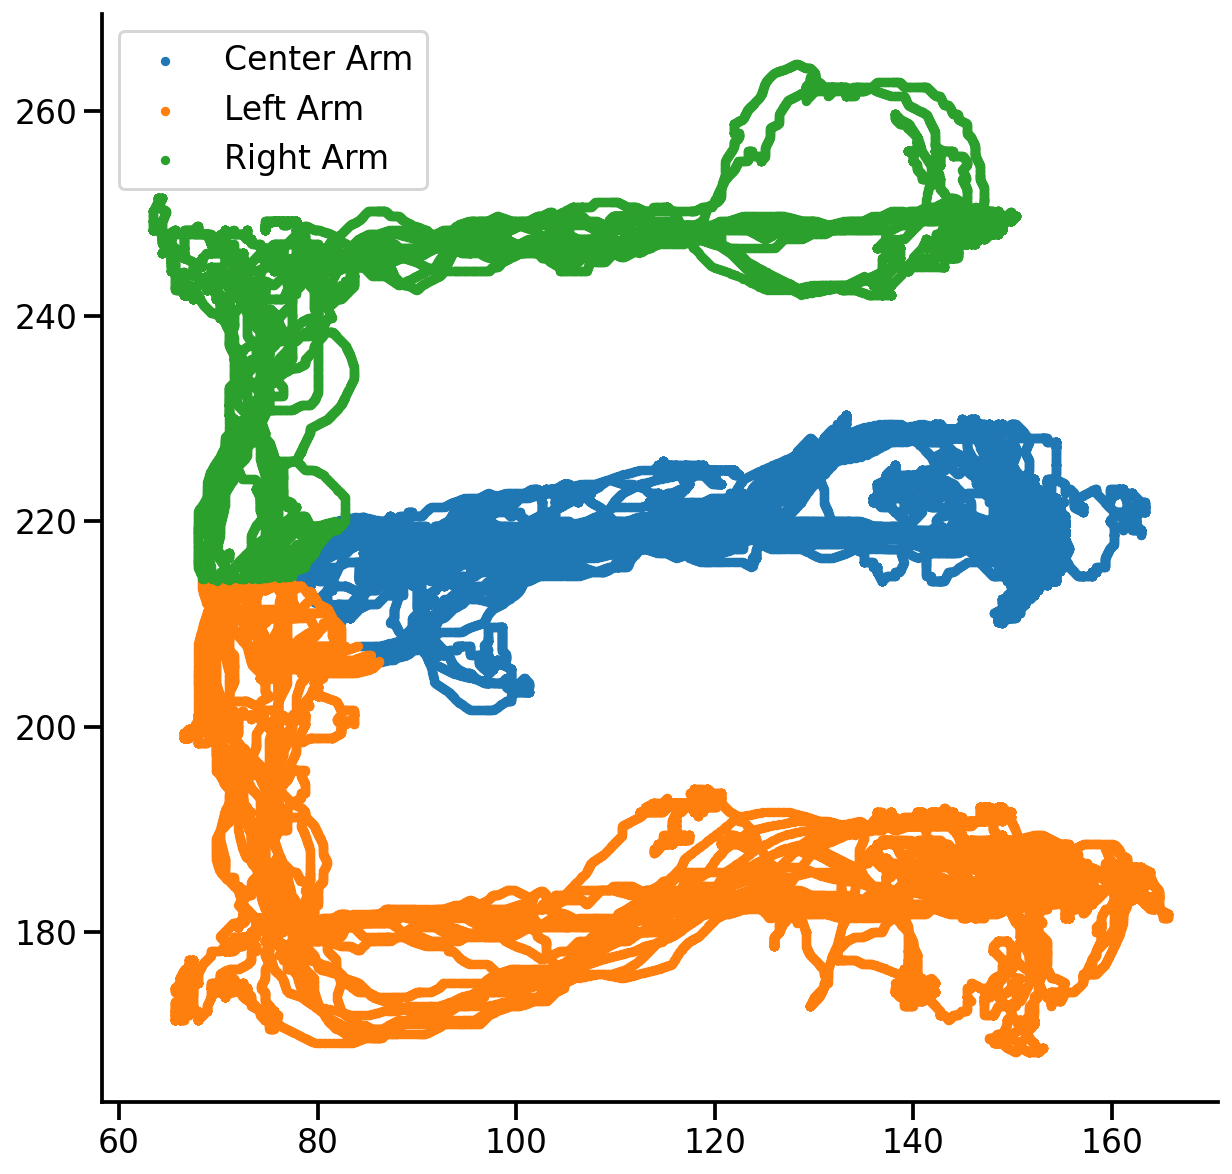

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in data["position_info"].groupby("arm_name"):
    print(task)
    ax.scatter(
        df.y_position,
        df.x_position,
        s=10,
        label=task,
    )

plt.legend()
sns.despine()

In [21]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [23]:
classifier = ClusterlessClassifier(**classifier_parameters)

cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):

    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition

    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )

5it [37:37, 451.55s/it]


In [56]:
import xarray as xr

cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)


TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

In [57]:
cv_classifier_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_results.nc"
)

In [26]:
def plot_local_non_local_time_slice_classifier(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
):
    cmap = plt.cm.viridis
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        4,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1]},
    )

    # ax 0
    results[posterior_type].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[0],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].set_ylabel("Position [cm]")

    axes[0].set_title("Posterior")

    axes[0].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[0].set_xlabel("")

    # ax 1
    results[posterior_type].sum("position").sel(time=time_slice).plot(
        x="time",
        hue="state",
        ax=axes[1],
    )
    axes[1].set_title("Probability")
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[2].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Firing Rate\n[spikes / s]")
    axes[2].set_title("Multiunit")

    # ax 3
    axes[3].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[3].set_ylabel("Speed [cm / s]")
    axes[3].set_xlabel("Time [ms]")
    sns.despine()

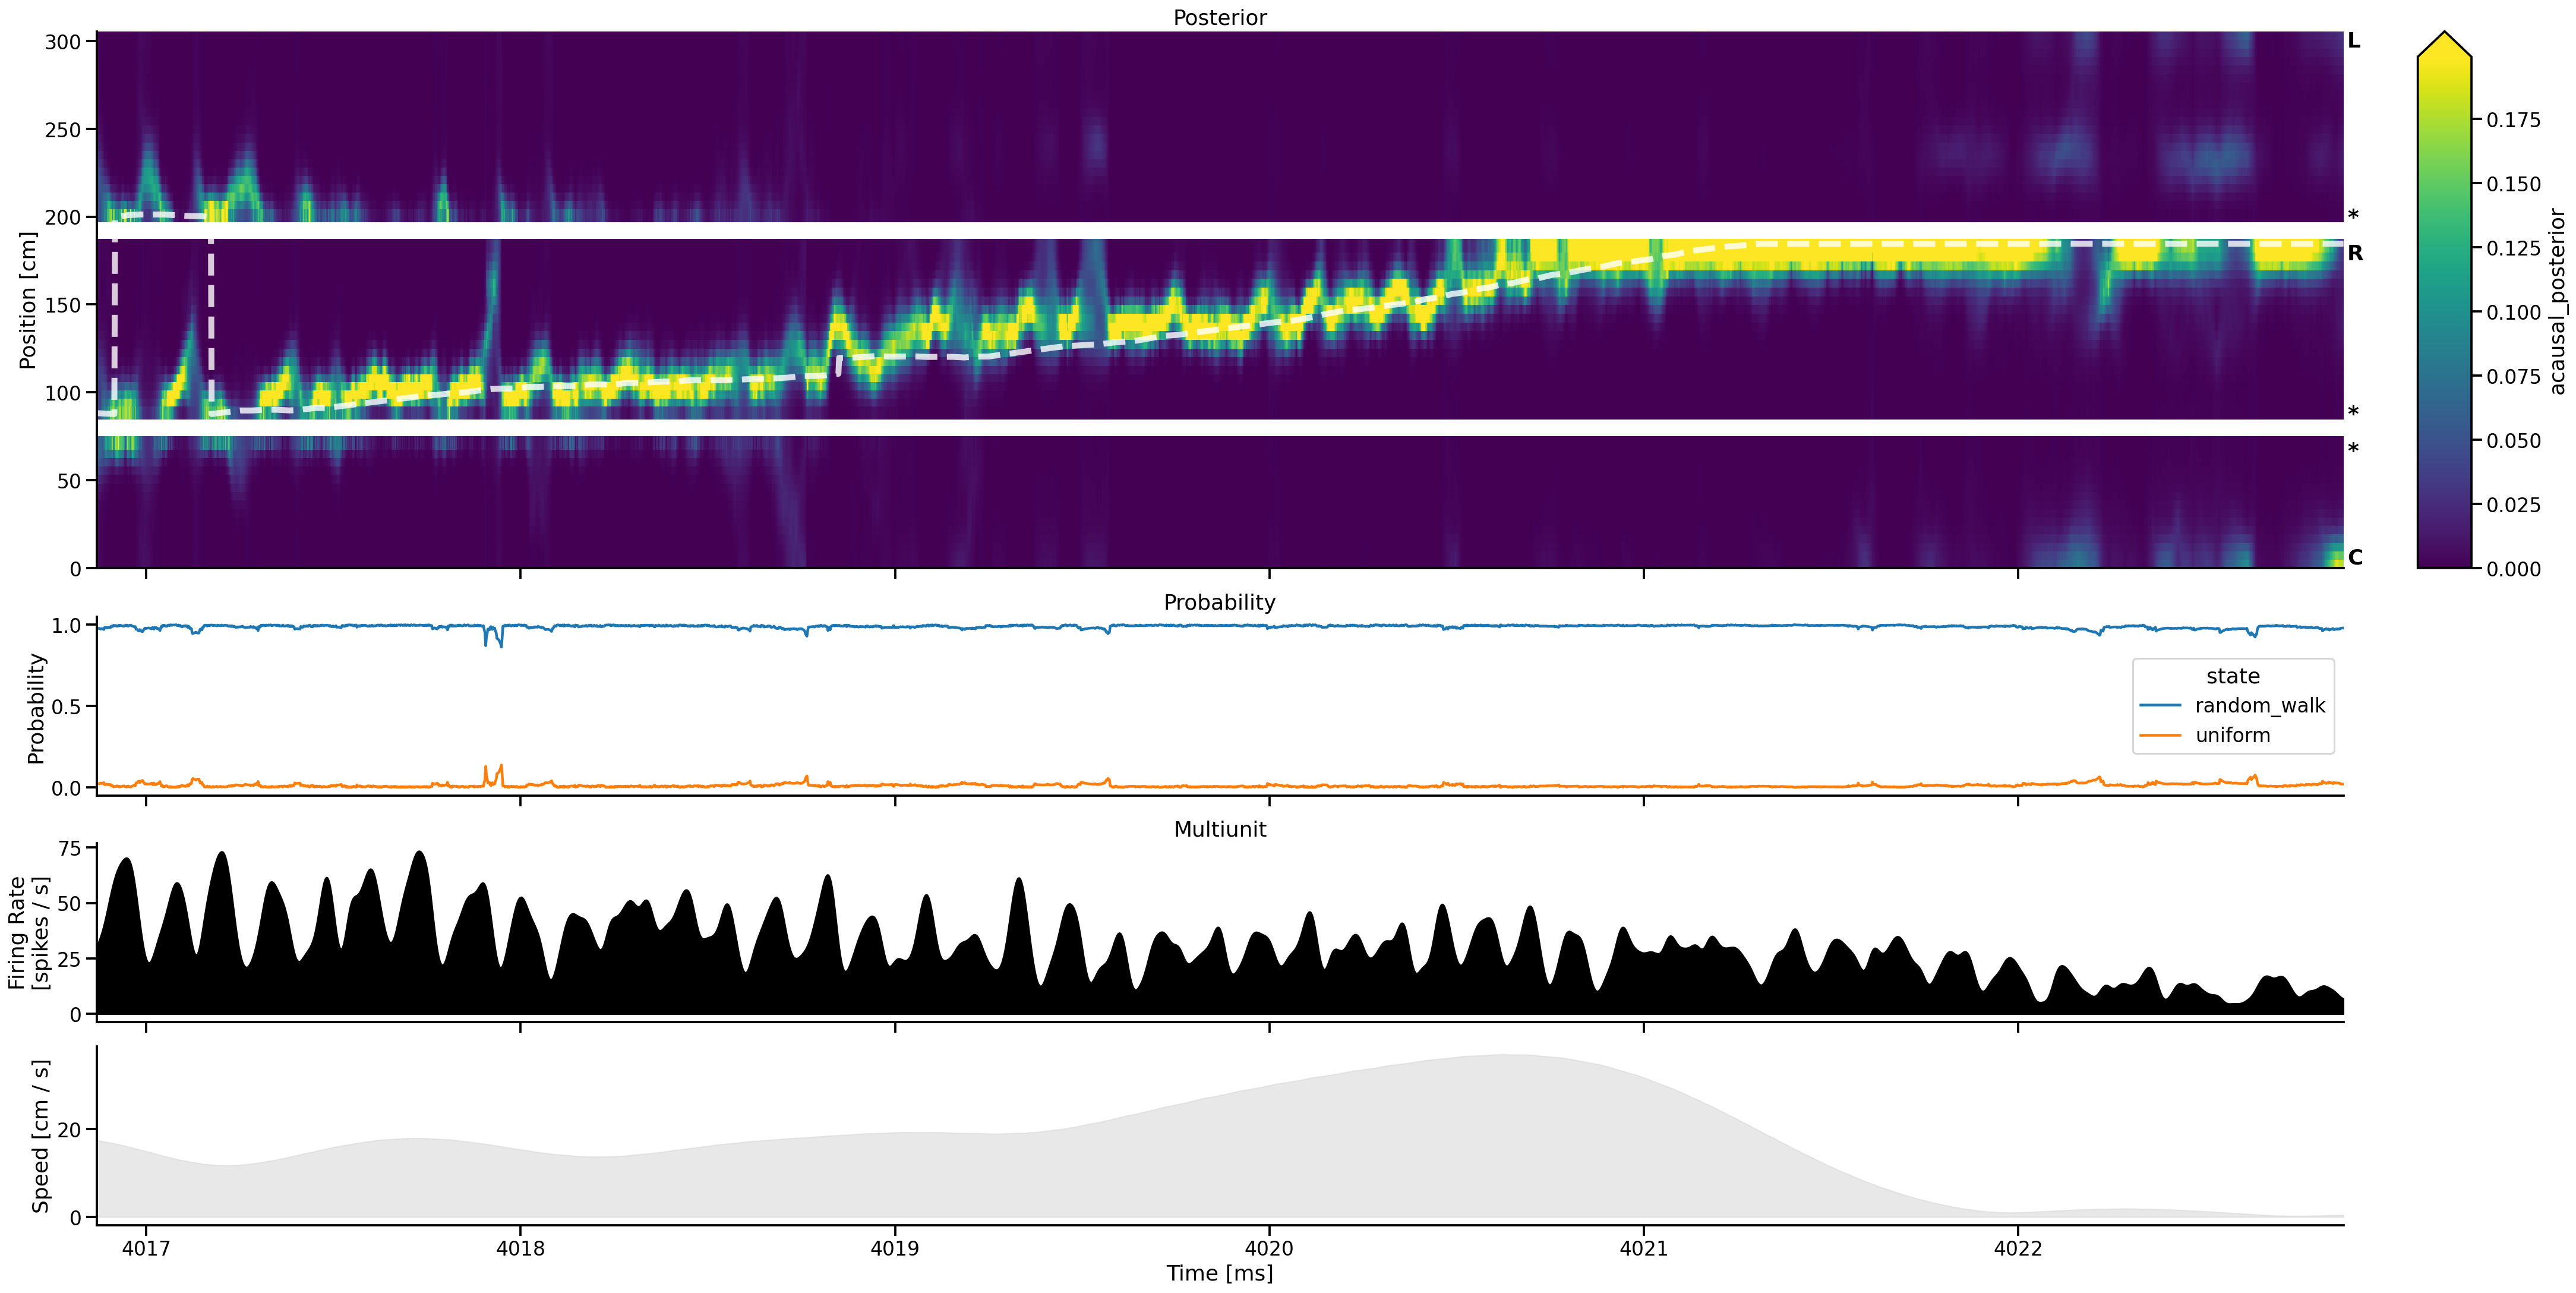

In [55]:
# extrat the time slice from the data but only is_running ones

# t = data["position_info"].index[np.where(is_running)[0]] / np.timedelta64(1, "s")
t = data["position_info"].index / np.timedelta64(1, "s")
# time_slice = slice(t.min() + 240.85, t.min() + 298.85)
time_slice = slice(t.min() + 370.85, t.min() + 376.85)
plot_local_non_local_time_slice_classifier(
    time_slice, classifier, cv_classifier_clusterless_results, data
)

In [35]:
t = data["position_info"].index[np.where(is_running)[0]] / np.timedelta64(1, "s")

In [39]:
np.where(is_running)

(array([     0,      1,      2, ..., 461586, 461587, 461588]),)